In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.tree import plot_tree



# Linear regression

In [2]:
def train_linear_regression(
    data: pd.DataFrame, 
    target: str, 
    alphas: list[int] = [0.1, 1, 10, 100],
    transformer: str = None,  # 'log', 'yeo-johnson', or None
    scaler: str = None,  # 'robust', 'standard', or None
    regularization: str = None,
    polynomial_degree: int = None,  # New parameter for polynomial features
    interaction_only: bool = False,  # New parameter to control interaction terms
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a linear regression model with optional regularization and polynomial features.
    Calculates R² correctly for transformed targets.
    Handles ordinal features with ordinal encoding.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset containing features and target
    target : str
        Name of the target variable column
    alphas : list[int]
        List of alpha values for regularization
    transformer : str
        Transformation for numerical features: 'log', 'yeo-johnson', or None
    scaler : str
        Scaling method for numerical features: 'robust', 'standard', or None
    regularization : str
        Regularization method: 'ridge', 'lasso', or None
    polynomial_degree : int
        If provided, adds polynomial features up to this degree
    interaction_only : bool
        If True, only interaction features are produced (no powers)
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
    """
    X = data.drop(target, axis=1)
    
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    
    # Separate nominal categorical columns 
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns 
                       if col not in ordinal_columns]
    
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Define ordinal mappings
    ordinal_mappings = {
        # Quality features (Ex, Gd, TA, Fa, Po)
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        
        # Overall quality and condition (1-10)
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        
        # Basement exposure
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        
        # Basement finish types
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    
    # Apply transformations to y
    y = data[target]
    use_log_transform = transformer == 'log'
    use_yeo_johnson = transformer == 'yeo-johnson'
    
    if use_log_transform:
        y = np.log1p(y)
        
    num_steps = []

    # Add polynomial features if specified
    if polynomial_degree is not None and polynomial_degree > 1:
        num_steps.append((
            'polynomial', 
            PolynomialFeatures(
                degree=polynomial_degree, 
                interaction_only=interaction_only, 
                include_bias=False
            )
        ))
    
    # Add transformer and scaler steps
    if transformer == 'log':
        num_steps.append(('transformer', FunctionTransformer(np.log1p, validate=True)))
        if scaler == 'robust':
            num_steps.append(('scaler', RobustScaler()))
        elif scaler == 'standard':
            num_steps.append(('scaler', StandardScaler()))

    elif transformer == 'yeo-johnson':
        if scaler == 'robust':
            num_steps.append(('scaler', RobustScaler()))
        elif scaler == 'standard':
            num_steps.append(('scaler', StandardScaler()))
        num_steps.append(('clipper', FunctionTransformer(lambda X: np.clip(X, -1e2, 1e2), validate=False)))
        num_steps.append(('transformer', PowerTransformer(method='yeo-johnson', standardize=False)))

    elif scaler == 'robust': #if there is no transformer but scaler is chosen.
        num_steps.append(('scaler', RobustScaler()))
    elif scaler == 'standard': #if there is no transformer but scaler is chosen.
        num_steps.append(('scaler', StandardScaler()))
    
    
    # Create the numeric pipeline
    if num_steps:
        num_pipeline = Pipeline(num_steps)
    else:
        num_pipeline = 'passthrough'
    
    # Create transformers for each ordinal feature
    ordinal_transformers = []
    for col in ordinal_columns:
        ordinal_transformers.append(
            (f'ord_{col}', 
                OrdinalEncoder(
                    categories=[list(ordinal_mappings[col].keys())],
                    handle_unknown='use_encoded_value',
                    unknown_value=-1
                ), 
                [col])
        )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_columns),
            ('num', num_pipeline, numerical_columns)
        ] + ordinal_transformers
    )

    # Select appropriate regressor
    if regularization == 'ridge':
        regressor = Ridge()
        param_grid = {'regressor__alpha': alphas}
    elif regularization == 'lasso':
        regressor = Lasso(max_iter=1000000, tol=0.01, selection='random') # for better stability reduced tolerance and increase max_iter
        param_grid = {'regressor__alpha': alphas}
    else:
        regressor = LinearRegression()
        param_grid = {}

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if regularization in ['ridge', 'lasso']:
        grid_search = GridSearchCV(
            model, 
            param_grid, 
            cv=10, 
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        best_model = model
        best_params = {}

    # Transform predictions back if needed
    if use_log_transform:
        # Apply safe expm1 by clipping extreme values
        max_safe_value = 30  # log(max_safe_value) is about 1.3e13
        y_pred_clipped = np.clip(y_pred, -max_safe_value, max_safe_value)
        y_test_clipped = np.clip(y_test, -max_safe_value, max_safe_value)
        y_pred = np.expm1(y_pred_clipped)
        y_test = np.expm1(y_test_clipped)
    elif use_yeo_johnson and y_test.min() >= 0:
        # Yeo-Johnson doesn't need inverse transform for positive values unless standardized
        pass
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Get feature importances - must handle the case where polynomial features are used
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        coef = best_model.named_steps['regressor'].coef_
        
        # Get feature names from the preprocessor
        try:
            # For scikit-learn >=1.0
            feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        except:
            # Build feature names manually
            feature_names = []
            
            # Add one-hot encoded nominal features
            if nominal_columns:
                feature_names.extend(
                    best_model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(nominal_columns)
                )
            
            # Add numerical features with polynomial features if used
            if polynomial_degree is not None and polynomial_degree > 1:
                num_transformer = best_model.named_steps['preprocessor'].named_transformers_['num']
                poly_transformer = None
                for name, transformer in num_transformer.steps:
                    if name == 'polynomial':
                        poly_transformer = transformer
                        break
                
                if poly_transformer:
                    feature_names.extend(
                        poly_transformer.get_feature_names_out(numerical_columns)
                    )
                else:
                    feature_names.extend(numerical_columns)
            else:
                feature_names.extend(numerical_columns)
            
            # Add ordinal features
            feature_names.extend(ordinal_columns)
        
        # Ensure the number of features matches the coefficients
        if len(feature_names) != len(coef):
            # If there's a mismatch, use generic feature names
            feature_names = [f'feature_{i}' for i in range(len(coef))]
        
        # Create coefficients DataFrame
        coefficients = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(coef),
            'value': coef
        }).sort_values('importance', ascending=False)
    else:
        coefficients = pd.DataFrame({
            'feature': ['N/A'],
            'importance': [0],
            'value': [0]
        })

    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': coefficients,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

In [3]:
df = pd.read_csv('data/train_rm_OL.csv') # in here outliers are removed
# df = pd.read_csv('data/train_cleaned.csv')

trans_options = [ 'log']  # 'yeo-johnson',
scaler_options = [None, 'robust'] #'stadard',
regularization_options = [None, 'ridge', 'lasso'] #'lasso',

best_r2 = float('-inf')
best_result = None

for trans in trans_options:
    for scaler in scaler_options:
        for regularization in regularization_options:
            alphas = [1, 10, 100, 1000, 10000] if regularization == 'ridge' else [0.0001, 0.001, 0.01, 0.1] if regularization == 'lasso' else None
            results = train_linear_regression(
                data=df,
                target='SalePrice',
                transformer=trans,
                scaler=scaler,
                regularization=regularization,
                alphas=alphas,  # Pass alphas if regularization is used
                polynomial_degree=None,
                # interaction_only=False
            )

            print(f'Results with transformer {trans}, scaler {scaler}, and regularization {regularization}:')
            for metric, value in results['performance'].items():
                print(f"{metric}: {value}")
            if regularization:
                print('The best alpha=', results['best_params']['regressor__alpha'])
            print("=" * 30)

            # Store the best model
            if results['performance']['r2_score'] > best_r2:
                best_r2 = results['performance']['r2_score']
                best_result = (trans, scaler, regularization, results)

if best_result:
    best_trans, best_scaler, best_regularization, best_results = best_result
    print("Best Model:")
    print(f"Transformer: {best_trans}")
    print(f"Scaler: {best_scaler}")
    print(f"Regularization: {best_regularization}")
    print(f"Best R2 Score: {best_r2}")
    print("Best Model Performance:")
    for metric, value in best_results['performance'].items():
        print(f"{metric}: {value}")
    if best_regularization:
        print('The best alpha=', best_results['best_params']['regressor__alpha'])
else:
    print("No results found.")

Results with transformer log, scaler None, and regularization None:
root_mean_squared_error: 20506.84557003565
r2_score: 0.9303711568899597
Results with transformer log, scaler None, and regularization ridge:
root_mean_squared_error: 20079.509740733938
r2_score: 0.9332428684584538
The best alpha= 10
Results with transformer log, scaler None, and regularization lasso:
root_mean_squared_error: 20976.259175268053
r2_score: 0.9271469835432417
The best alpha= 0.001
Results with transformer log, scaler robust, and regularization None:
root_mean_squared_error: 20460.00422472877
r2_score: 0.9306888833520197
Results with transformer log, scaler robust, and regularization ridge:
root_mean_squared_error: 19797.471118105615
r2_score: 0.9351050512649575
The best alpha= 10
Results with transformer log, scaler robust, and regularization lasso:
root_mean_squared_error: 21090.376126290597
r2_score: 0.9263521441308729
The best alpha= 0.001
Best Model:
Transformer: log
Scaler: robust
Regularization: ridg

The result for the best model:

In [10]:
# df = pd.read_csv('data/train_cleaned.csv')
df = pd.read_csv('data/train_rm_OL.csv')


results = train_linear_regression(
    data=df,
    target='SalePrice',
    transformer='log',  
    scaler='standard',            
    regularization='ridge',
    alphas = [1, 10, 100, 1000, 10000]
)
for metric, value in results['performance'].items():
    print(f"{metric}: {value}")
print('The best alpha=', results['best_params']['regressor__alpha'])
print("=" * 30)



root_mean_squared_error: 19640.725695885572
r2_score: 0.936128587857078
The best alpha= 10


Removing outliers results in overall better performance of LR models. This is perhaps a hint to use this dataset for training.

### Linear regression conclusions:

This result is pretty impresive for linear regression.

From above we can see, that the best R2 is obtained for data without outliers 

# Decision tree

In [ ]:

# from sklearn.tree import DecisionTreeRegressor

# def train_decision_tree_regression(
#     data: pd.DataFrame, 
#     target: str, 
#     max_depth: list[int] = [2, 3, 5, 7, 10],
#     min_samples_splits: list[int] = [2, 5, 10],
#     min_samples_leaf: list[int] = [1, 2, 4],
#     max_features: list[int, float, str] = [None, 'sqrt', 'log2'],
#     num_transformer: str = 'robust',
#     test_size: float = 0.2, 
#     random_state: int = 42
# ):
#     """
#     Train a decision tree regression model with pruning and advanced preprocessing.
#     Supports various numerical transformations and handles categorical features.
    
#     Parameters:
#     -----------
#     data : pd.DataFrame
#         Input dataset
#     target : str
#         Name of the target column
#     pruning_depths : list
#         Maximum depths to test for pruning
#     min_samples_splits : list
#         Minimum number of samples required to split an internal node
#     num_transformer : str
#         Numerical feature transformation method
#         Options: 'robust', 'standard', 'log', 'log+robust', 'log+standard'
#     test_size : float
#         Proportion of the dataset to include in the test split
#     random_state : int
#         Random seed for reproducibility
    
#     Returns:
#     --------
#     dict : A dictionary containing model, performance metrics, 
#            best parameters, and feature importances
#     """
#     # Separate features and target
#     X = data.drop(target, axis=1)
    
#     # Identify column types
#     categorical_columns = X.select_dtypes(include=['object', 'category']).columns
#     numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
#     # Log transformer for skewed features
#     log_transformer = FunctionTransformer(np.log1p, validate=True)
    
#     # Determine scaling and target transformation
#     y = data[target]
#     use_log_transform = num_transformer in ['log', 'log+robust', 'log+standard']
    
#     # Create numerical preprocessing pipeline
#     if num_transformer == 'robust': 
#         num_pipeline = RobustScaler()
#     elif num_transformer == 'standard': 
#         num_pipeline = StandardScaler()
#     elif num_transformer == 'log+robust':
#         num_pipeline = Pipeline([
#             ('log', log_transformer),
#             ('scaler', RobustScaler())
#         ])
#         y = np.log1p(y)
#     elif num_transformer == 'log+standard':
#         num_pipeline = Pipeline([
#             ('log', log_transformer),
#             ('scaler', StandardScaler())
#         ])
#         y = np.log1p(y)
#     elif num_transformer == 'log':
#         num_pipeline = log_transformer
#         y = np.log1p(y)
#     else:
#         num_pipeline = 'passthrough'

#     # Create preprocessor with one-hot encoder for categories
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
#             ('num', num_pipeline, numerical_columns)
#         ])


#     param_grid = {
#     'regressor__max_depth': max_depth,
#     'regressor__min_samples_split': min_samples_splits,
#     'regressor__min_samples_leaf': min_samples_leaf,
#     'regressor__max_features': max_features
# }

#     model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', DecisionTreeRegressor(random_state=random_state))
#     ])

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     grid_search = GridSearchCV(
#         model, 
#         param_grid, 
#         cv=10, 
#         scoring='neg_root_mean_squared_error'
#     )
#     grid_search.fit(X_train, y_train)
    
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     y_pred = best_model.predict(X_test)

#     if use_log_transform:
#         # Inverse transform predictions and actual values
#         y_pred = np.expm1(y_pred)
#         y_test = np.expm1(y_test)
        

#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)

#     # Get feature names from model because one-hot encoding
#     feature_names = (
#         list(best_model.named_steps['preprocessor']
#              .named_transformers_['cat']
#              .get_feature_names_out(categorical_columns)) + 
#         list(numerical_columns)
#     )
    
#     # Extract feature importances
#     importances = best_model.named_steps['regressor'].feature_importances_
#     feature_importances = pd.DataFrame({
#         'feature': feature_names,
#         'importance': importances
#     }).sort_values('importance', ascending=False)

#     return {
#         'model': best_model,
#         'performance': {
#             'root_mean_squared_error': rmse,
#             'r2_score': r2
#         },
#         'best_params': best_params,
#         'feature_importances': feature_importances,
#         'train_data': (X_train, y_train),
#         'test_data': (X_test, y_test)
#     }

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder

def train_decision_tree_regression(
    data: pd.DataFrame, 
    target: str, 
    max_depth: list[int] = [2, 3, 5, 7, 10],
    min_samples_splits: list[int] = [2, 5, 10],
    min_samples_leaf: list[int] = [1, 2, 4],
    max_features: list[int, float, str] = [None, 'sqrt', 'log2'],
    num_transformer: str = 'robust',
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a decision tree regression model with pruning and advanced preprocessing.
    Supports various numerical transformations and handles categorical features.
    Properly handles ordinal features using ordinal encoding.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset
    target : str
        Name of the target column
    pruning_depths : list
        Maximum depths to test for pruning
    min_samples_splits : list
        Minimum number of samples required to split an internal node
    num_transformer : str
        Numerical feature transformation method
        Options: 'robust', 'standard', 'log', 'log+robust', 'log+standard'
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : A dictionary containing model, performance metrics, 
           best parameters, and feature importances
    """
    # Separate features and target
    X = data.drop(target, axis=1)
    
    # Define feature types
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    
    # Keep only ordinal columns that actually exist in the dataset
    ordinal_columns = [col for col in ordinal_columns if col in X.columns]
    
    # Separate remaining categorical columns (nominal)
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns 
                       if col not in ordinal_columns]
    
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Define ordinal mappings
    ordinal_mappings = {
        # Quality features (Ex, Gd, TA, Fa, Po)
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        
        # Overall quality and condition (1-10)
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        
        # Basement exposure
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        
        # Basement finish types
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    
    # Log transformer for skewed features
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    
    # Determine scaling and target transformation
    y = data[target]
    use_log_transform = num_transformer in ['log', 'log+robust', 'log+standard']
    
    # Create numerical preprocessing pipeline
    if num_transformer == 'robust': 
        num_pipeline = RobustScaler()
    elif num_transformer == 'standard': 
        num_pipeline = StandardScaler()
    elif num_transformer == 'log+robust':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', RobustScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log+standard':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', StandardScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log':
        num_pipeline = log_transformer
        y = np.log1p(y)
    else:
        num_pipeline = 'passthrough'

    # Create transformers for each ordinal feature
    ordinal_transformers = []
    for col in ordinal_columns:
        if col in ordinal_mappings:
            ordinal_transformers.append(
                (f'ord_{col}', 
                 OrdinalEncoder(
                     categories=[list(ordinal_mappings[col].keys())],
                     handle_unknown='use_encoded_value',
                     unknown_value=-1
                 ), 
                 [col])
            )

    # Create preprocessor with one-hot encoder for nominal categories
    # and ordinal encoder for ordinal categories
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_columns),
            ('num', num_pipeline, numerical_columns)
        ] + ordinal_transformers
    )

    param_grid = {
        'regressor__max_depth': max_depth,
        'regressor__min_samples_split': min_samples_splits,
        'regressor__min_samples_leaf': min_samples_leaf,
        'regressor__max_features': max_features
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=random_state))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=10, 
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    if use_log_transform:
        # Inverse transform predictions and actual values
        y_pred = np.expm1(y_pred)
        y_test = np.expm1(y_test)
        
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Get feature names from model - needs to be handled differently with ordinal features
    feature_names = []
    
    # Add one-hot encoded nominal features
    if nominal_columns:
        feature_names.extend(
            best_model.named_steps['preprocessor']
            .named_transformers_['cat']
            .get_feature_names_out(nominal_columns)
        )
    
    # Add numerical features
    feature_names.extend(numerical_columns)
    
    # Add ordinal features
    feature_names.extend(ordinal_columns)
    
    # Extract feature importances
    importances = best_model.named_steps['regressor'].feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'type': ['Numerical' if col in numerical_columns else 
                 'Ordinal' if col in ordinal_columns else 
                 'Categorical' for col in feature_names]
    }).sort_values('importance', ascending=False)

    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': feature_importances,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

Results with preprocessing robust:
root_mean_squared_error: 33598.86918507799
r2_score: 0.8130864528788454
{'regressor__max_depth': 20, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20}
Best model:
Preprocessing: robust
root_mean_squared_error: 33598.86918507799
r2_score: 0.8130864528788454
{'regressor__max_depth': 20, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20}


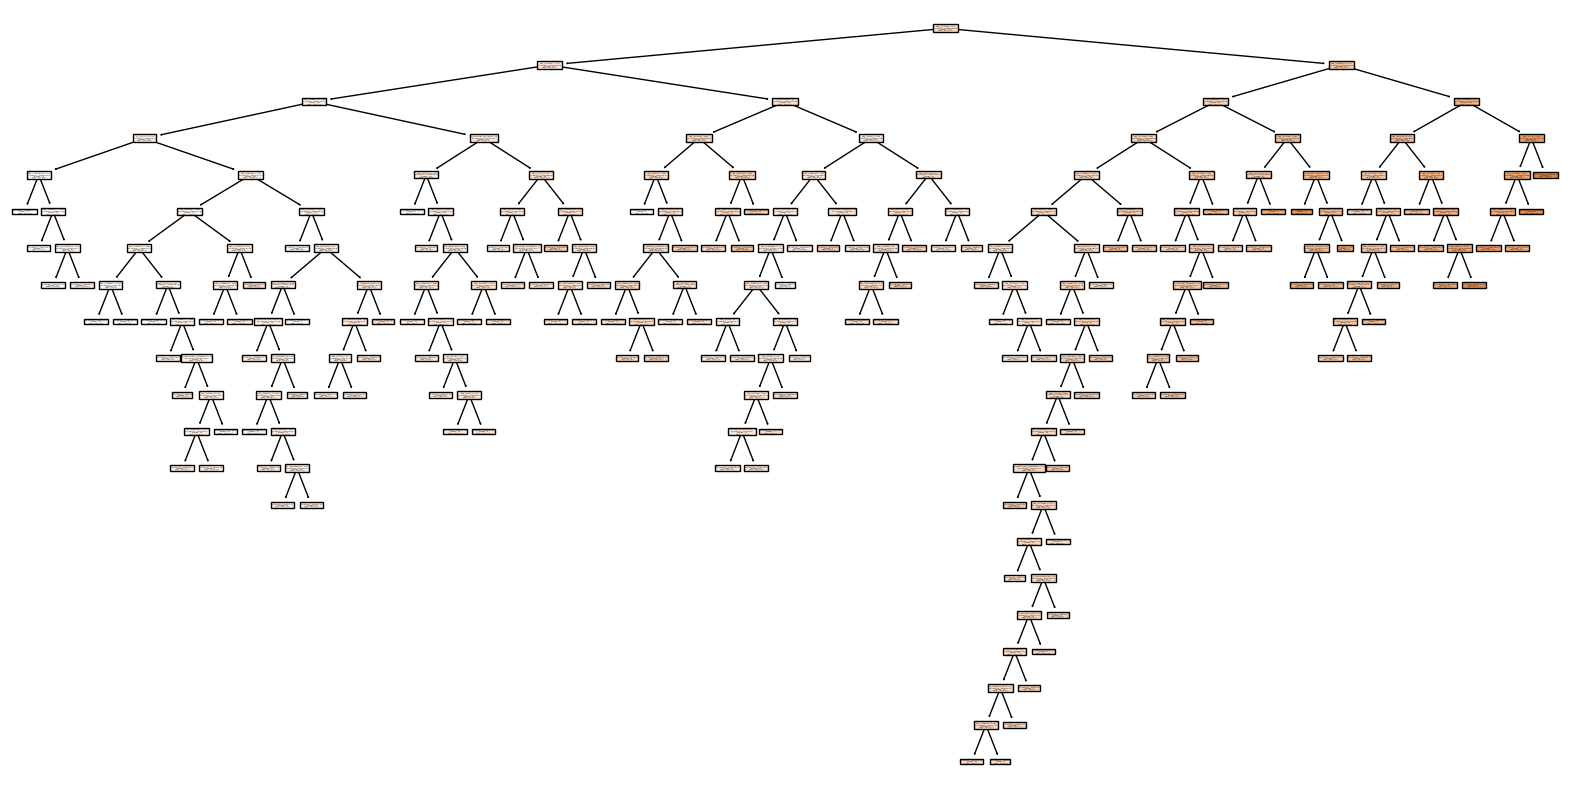

In [3]:
# df = pd.read_csv('data/train_cleaned.csv')
df = pd.read_csv('data/train_rm_OL.csv')
trans_options = ['robust'] # this is the best preprocessing
# trans_options = ['robust', 'standard', 'log', 'log+robust', 'log+standard']

best_r2 = float('-inf')
best_result = None

for trans in trans_options:
    results_tree = train_decision_tree_regression(
        df, target='SalePrice', min_samples_splits=[10, 20], max_depth=[15, 20], max_features=[None],  num_transformer=trans
    )
    
    print(f'Results with preprocessing {trans}:')
    for metric, value in results_tree['performance'].items():
        print(f"{metric}: {value}")
    print(results_tree['best_params'])
    
    # Store the best model
    if results_tree['performance']['r2_score'] > best_r2:
        best_r2 = results_tree['performance']['r2_score']
        best_result = (trans, results_tree)

# Print the best model at the end and visualize it
if best_result:
    trans, results_tree = best_result
    best_model = results_tree['model'].named_steps['regressor']  # Extract regressor from pipeline
    preprocessor = results_tree['model'].named_steps['preprocessor']  # Extract preprocessor from pipeline
    
    # Get transformed feature names
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop('SalePrice', axis=1).columns
    feature_names = feature_names = preprocessor.get_feature_names_out()
    # (
    #     list(preprocessor.named_transformers_['cat'].get_feature_names_out()) +
    #     list(numerical_columns)
    # )

    print("Best model:")
    print(f"Preprocessing: {trans}")
    for metric, value in results_tree['performance'].items():
        print(f"{metric}: {value}")
    print(results_tree['best_params'])

    # Visualizing the tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, filled=True, feature_names=feature_names)
    plt.show()


Trees are way worse than linear regression, which may indicate that non-linearities are not extreme in the dataset.